# ACE Exploration: Peptide Feature Similarities Exploration

### Dhuvarakesh Karthikeyan and Jin Seok (Andy) Lee

In [237]:
#Import Dependencies

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import difflib
from collections import Counter

import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

In [6]:
_PROTBERT_TOKENIZER = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
_PROTBERT_MODEL = BertModel.from_pretrained("Rostlab/prot_bert")

Downloading:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Load in the Data

In [120]:
vdjdb = pd.read_csv("vdjdb_12032022.tsv", sep='\t')
unique_cdr3s = vdjdb['CDR3'].unique()
len(unique_cdr3s)

36693

In [125]:
# Helper Function for Aggregating Data
def feature_dist(df, feature, asc=False):
    counts = dict(Counter(df[feature]))
    df = pd.DataFrame(list(counts.items()), columns = [str(feature), 'Frequency'])
    return df.sort_values(by='Frequency', ascending=asc).reset_index(drop=True)

In [155]:
sorted_df = feature_dist(vdjdb, "CDR3")
target_df = sorted_df[sorted_df['Frequency'] > 2]

### Sequence Similarity Metrics

In [248]:
 def embed(sequence, tokenizer=_PROTBERT_TOKENIZER, encoder=_PROTBERT_MODEL):
        encoded_input = tokenizer(" ".join(sequence), return_tensors='pt')
        output = encoder(**encoded_input)
        return torch.mean(output.last_hidden_state, 1).detach().numpy()[0]

def cosine_similarity(emb1, emb2):
    return np.dot(emb1, emb2) / (np.linalg.norm(emb1)*np.linalg.norm(emb2))

def dummy_embed(sequence):
    return sequence

def kmer_similarity(seq1, seq2):
    return difflib.SequenceMatcher(None, seq1, seq2).find_longest_match().size

def ratio_similarity(seq1, seq2):
    return difflib.SequenceMatcher(None, seq1, seq2).ratio()

def calc_ingroup_features(cdr3s, feature_fxn, sim_fxn):
    ingroup_sims = []
    for cdr3 in cdr3s:
        epitopes = vdjdb[vdjdb['CDR3']==cdr3]['Epitope'].unique()
        pairs = [(epi1, epi2) for idx, epi1 in enumerate(epitopes) for epi2 in epitopes[idx + 1:]]
        for pair in pairs:
            ingroup_sims += [sim_fxn(feature_fxn(pair[0]), feature_fxn(pair[1]))]
    return ingroup_sims

def calc_outgroup_features(cdr3s, feature_fxn, sim_fxn, n=1000):
    outgroup_sims = []
    tcr_pairs = [(tcr1, tcr2) for idx, tcr1 in enumerate(cdr3s) for tcr2 in cdr3s[idx + 1:]]
    for tcr_pair in random.sample(tcr_pairs, n):
        epi1s = vdjdb[vdjdb['CDR3']==tcr_pair[0]]['Epitope'].unique()
        epi2s = vdjdb[vdjdb['CDR3']==tcr_pair[1]]['Epitope'].unique()
        for e1 in epi1s:
            for e2 in epi2s:
                    if e1 != e2:
                        outgroup_sims += [sim_fxn(feature_fxn(e1), feature_fxn(e2))]
    return outgroup_sims


### ProtBERT Embedding Similarities

In [272]:
### Find the BERT Embedding Similarity of Epitopes that share a common TCR

ingroup_sims = calc_ingroup_features(target_df['CDR3'], embed, cosine_similarity)

In [273]:
### Find the Similarity of Epitopes that do not share a TCR

outgroup_sims = calc_outgroup_features(target_df['CDR3'], embed, cosine_similarity, n=1000)

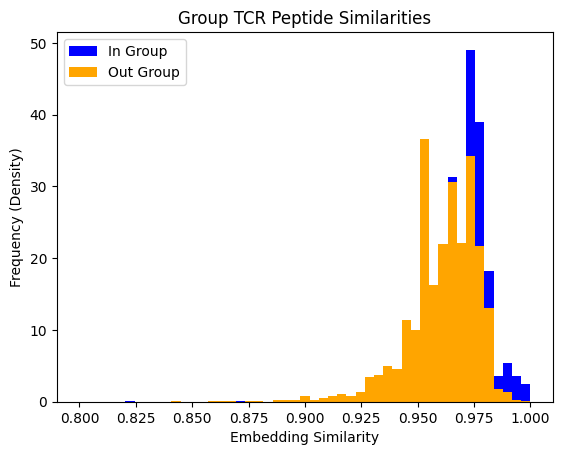

In [274]:
plt.hist(ingroup_sims,  bins=np.linspace(.8,1,50), density = True, color='blue')
plt.hist(outgroup_sims, bins=np.linspace(.8,1,50), density = True, color='orange')
plt.legend(['In Group', 'Out Group'])
plt.title('Group TCR Peptide Similarities')
plt.xlabel('Embedding Similarity')
plt.ylabel('Frequency (Density)')
plt.show()

### Sequence K-mer Similarities

In [269]:
### Find the Kmer Similarity of Epitopes that share a common TCR

ingroup_sims2 = calc_ingroup_features(target_df['CDR3'], dummy_embed, kmer_similarity)

In [270]:
### Find the Kmer Similarity of Epitopes that DO NOT share a common TCR

outgroup_sims2 = calc_outgroup_features(target_df['CDR3'], dummy_embed, kmer_similarity)

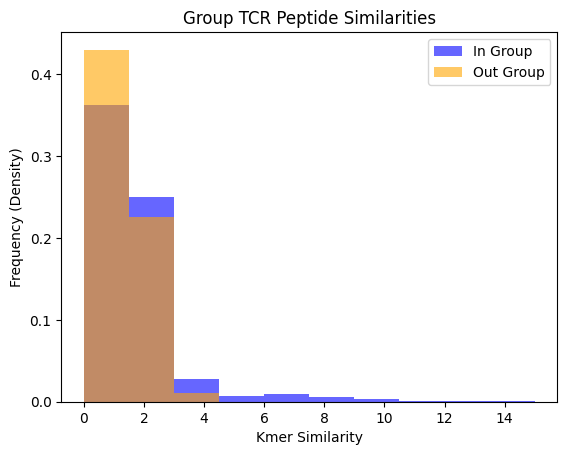

In [271]:
plt.hist(ingroup_sims2, density = True, color='blue', alpha = 0.6)
plt.hist(outgroup_sims2,  density = True, color='orange', alpha = 0.6)
plt.legend(['In Group', 'Out Group'])
plt.title('Group TCR Peptide Similarities')
plt.xlabel('Kmer Similarity')
plt.ylabel('Frequency (Density)')
plt.show()

### Sequence Ratio Similarity

$$ Ratio = 2*\frac{Matches}{Total}$$

In [266]:
### Find the Ratio Similarity of Epitopes that share a common TCR

ingroup_sims3 = calc_ingroup_features(target_df['CDR3'], dummy_embed, ratio_similarity)

In [267]:
### Find the Ratio Similarity of Epitopes that DO NOT share a common TCR

outgroup_sims3 = calc_outgroup_features(target_df['CDR3'], dummy_embed, ratio_similarity)

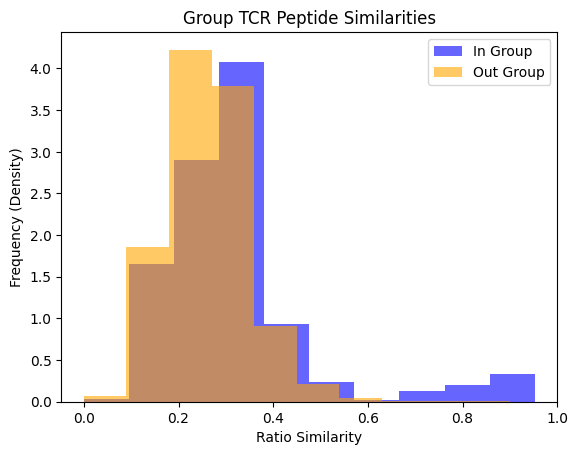

In [268]:
plt.hist(ingroup_sims3, density = True, color='blue', alpha = 0.6)
plt.hist(outgroup_sims3,  density = True, color='orange', alpha = 0.6)
plt.legend(['In Group', 'Out Group'])
plt.title('Group TCR Peptide Similarities')
plt.xlabel('Ratio Similarity')
plt.ylabel('Frequency (Density)')
plt.show()

In [17]:
import tkinter

In [18]:

def get_tkinter_root():
    root = tkinter.Tk()
    root.withdraw()
    root.wm_attributes('-topmost', 1)

In [20]:
def btn_csv_click():
    get_tkinter_root()
    return tkinter.filedialog.askopenfilename(title = "Select file",filetypes = (("CSV Files","*.csv"),))

In [21]:
btn_csv_click()

AttributeError: module 'tkinter' has no attribute 'filedialog'